In [1]:
import torchvision
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil
import cv2

from sklearn.cluster import AgglomerativeClustering as AGC

In [2]:
# Data Path
image_root = Path("../images")
image_paths = list(image_root.glob("*"))

# VGG Part
device = "cpu"

resize = torchvision.transforms.Resize((2400, 3600))
vgg16_ = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1).to(device=device)

In [3]:
image_paths

[WindowsPath('../images/2021-01-09 15.40.49.jpg'),
 WindowsPath('../images/2021-01-09 15.41.01.jpg'),
 WindowsPath('../images/2021-01-09 15.41.13.jpg'),
 WindowsPath('../images/ToProcess'),
 WindowsPath('../images/viber_image_2023-03-05_19-10-45-186.jpg'),
 WindowsPath('../images/viber_image_2023-03-05_19-10-45-734.jpg')]

In [4]:
img = resize(torchvision.io.read_image(image_paths[-1].as_posix())).to(device=device, dtype=torch.float)

In [117]:
def plot_features(feature_list:torch.Tensor, feature, feature_id, save=False):
    print(feature_list.shape)
    col_count = int(feature_list.shape[0]**0.5)
    row_count = ceil(feature_list.shape[0] / col_count)
    
    fig, axes = plt.subplots(row_count, col_count, figsize=(50, 50))
    plt.xticks
    plt.suptitle(str(feature))
    
    ind = 0
    for i in range(row_count):
        for j in range(col_count):
            if ind >= feature_list.shape[0]:
                break
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])
            
            axes[i,j].set_title(i*col_count+j)
            axes[i,j].imshow(feature_list[i*col_count+j])
            ind += 1
    plt.tight_layout()
    if save:
        plt.savefig(f"./Features/{feature_id}_{str(feature).split('(')[0]}.png")
    else:
        plt.show()

def get_n_percent_val(inp, n=0.9):
    if isinstance(inp, np.ndarray):
        inp = torch.from_numpy(inp)
    if n>1 or n<0:
        print("`n` should be a number in [0,1] range")
    values, indices = torch.sort(inp.flatten())
    return values[int(n*(len(values)-1))]  

def extend_lines(feature, orientation, dilation_count=1, erode_count=1, line_min_width=50, dilation_line_min_width=150):
    if orientation.lower() not in ["vertical","horizontal"]:
        raise ValueError('`orientation` should be one of the following  ["vertical","horizontal"]')
        
    kernel_erosion = np.ones((1,line_min_width), np.uint8)
    kernel_dilation = np.ones((1,dilation_line_min_width), np.uint8)
    
    if orientation.lower()=="vertical":
        kernel_erosion = kernel_erosion.T
        kernel_dilation = kernel_dilation.T
    
    ## Erode for removing extra small lines
    img_bin = cv2.erode(feature.numpy().astype(np.uint8), kernel_erosion, erode_count) 
    ## Dilate for getting better expressed lines
    img_bin = cv2.dilate(img_bin, kernel_dilation, dilation_count)
    
    return img_bin

def plot_islands(*labeled_imgs):
    '''
    A function for finding the separated lines in the binary image and plotting each group in different color
    '''
    for labeled_img in labeled_imgs:
        # Applying cv2.connectedComponents() 
        _labeled_img = labeled_img.copy()
        # Map component labels to hue val, 0-179 is the hue range in OpenCV
        label_hue = np.uint8(179*_labeled_img/np.max(_labeled_img))
        blank_ch = 255*np.ones_like(label_hue)
        _labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

        # Converting cvt to BGR
        _labeled_img = cv2.cvtColor(_labeled_img, cv2.COLOR_HSV2BGR)

        # set bg label to black
        _labeled_img[label_hue==0] = 0

        #Showing Image after Component Labeling
        plt.imshow(cv2.cvtColor(_labeled_img, cv2.COLOR_BGR2RGB))
#         plt.axis('off')
        plt.title("Image after Component Labeling")
        plt.show()
    
    return _labeled_img


def change_range(x, old_min: float, old_max: float, new_min: float, new_max: float):
    """
    Change a number from one range to another.

    :param number: The number to change the range of.
    :param old_min: The minimum value of the current range.
    :param old_max: The maximum value of the current range.
    :param new_min: The minimum value of the new range.
    :param new_max: The maximum value of the new range.
    :return: The number in the new range.
    """
    
    # Calculate the ratio between the old and new ranges
    ratio = (x - old_min) / (old_max - old_min)
    
    # Calculate and return the corresponding value in the new range
    return ratio * (new_max - new_min) + new_min

def get_small_line_indices(group_areas, diff_threshold=3000):
    sort_mask = np.argsort(group_areas)
    # Finding the places
    break_indices = np.where(np.diff(group_areas[sort_mask])<diff_threshold)[0]
    if break_indices.shape[0]>0:
        return sort_mask[:break_indices[-1]]
    else:
        return []
    
def filter_out_small_lines(dilated_binary_image, difference_threshold):
    num_groups, grouped = cv2.connectedComponents(dilated_binary_image, connectivity=8)
    group_areas = np.array([((grouped==i).sum()) for i in range(num_groups)])
    for i in get_small_line_indices(group_areas, difference_threshold):
        grouped[grouped==i] = 0
    
    return grouped

def get_clean_lines(dilated_binary_image:np.ndarray, difference_threshold:float, vertical:bool):
    '''
    Returns 1. the grouped image of connected pixels, 
            2. average lines (pt1, pt2) for connected pixels,
            3. an image with those lines on it
    '''
    num_groups, grouped = cv2.connectedComponents(dilated_binary_image, connectivity=8)
    group_areas = np.array([((grouped==i).sum()) for i in range(num_groups)])
    
    lines = []
    clean_lined_image = np.zeros_like(dilated_binary_image)
    for i in get_big_line_indices(group_areas, difference_threshold):
        print(i)
        group_indices = np.where(grouped==i)
        xmean = int(group_indices[0].mean())
        ymean = int(group_indices[1].mean())
        pt1 = (xmean*vertical,
               ymean*(not vertical))
        
        pt2 = (dilated_binary_image.shape[1]*(not vertical)+pt1[0],
               dilated_binary_image.shape[0]*vertical + pt1[1])
        lines.append((pt1, pt2))
        clean_lined_image = cv2.line(clean_lined_image, pt1, pt2, color=(255,255,255), thickness=10)
        
    
    return grouped, lines, clean_lined_image

In [ ]:
feature_images = [img.clone()]

for i, feature in tqdm(enumerate(vgg16_.features[:9])):
    feature_images.append(feature(feature_images[-1]).detach())

# Dilating the lines (Important)

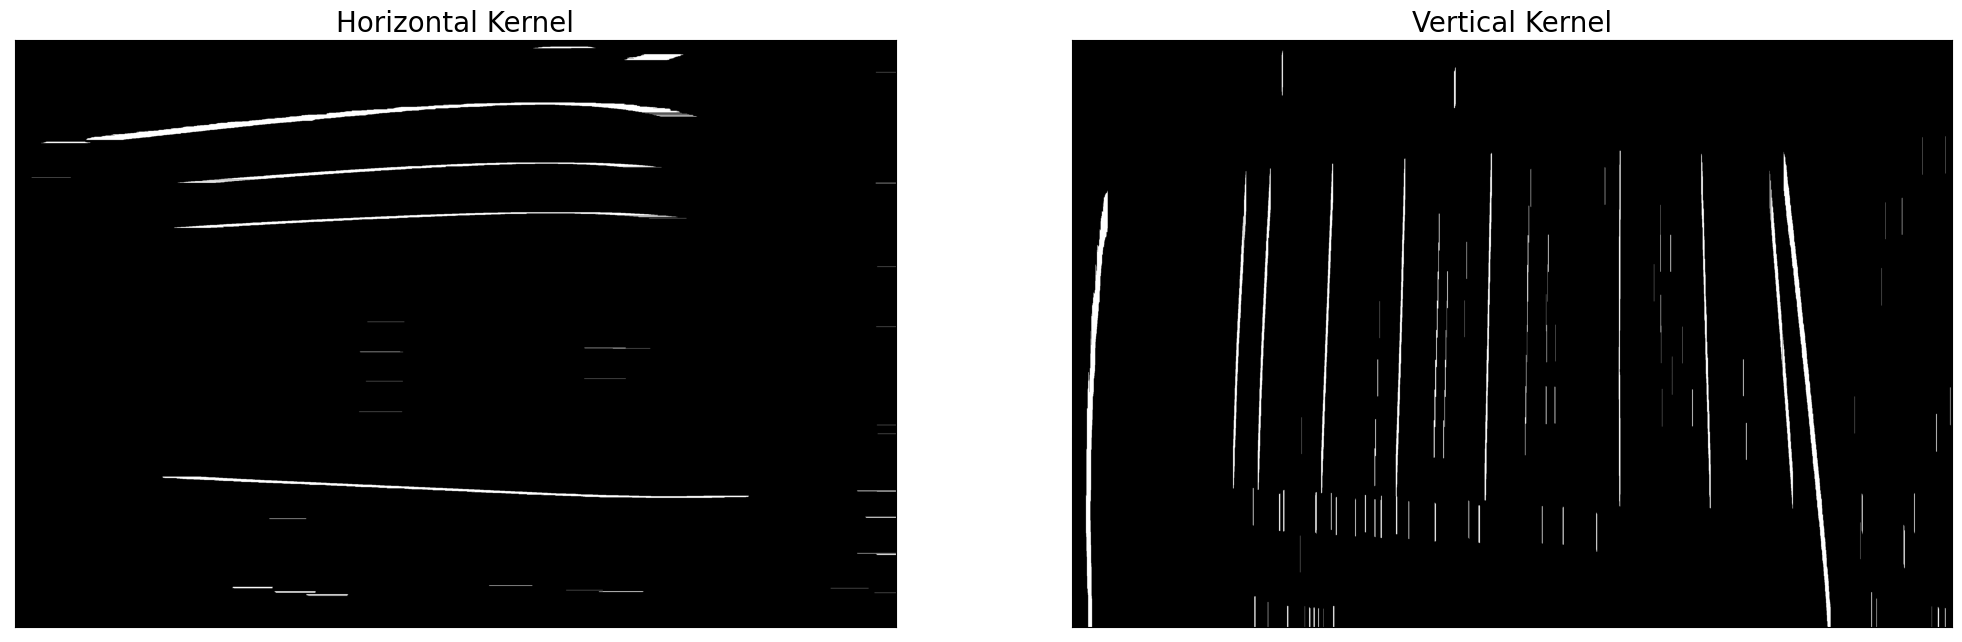

In [65]:
# Selecting Features for vertical and horizontal lines
vline = feature_images[1][17]
hline = feature_images[1][9]
v_b = vline>get_n_percent_val(vline, 0.95) ## Small threshold for small filtration
h_b = hline>get_n_percent_val(hline, 0.95) ## Small threshold for small filtration


img_bin_h = extend_lines(h_b, orientation="horizontal")
img_bin_v = extend_lines(v_b, orientation="vertical")

plt.figure(figsize=(25,25))


plt.subplot(121),plt.imshow(img_bin_h, cmap="gray")
plt.title('Horizontal Kernel', fontsize=20), plt.xticks([]), plt.yticks([])


plt.subplot(122),plt.imshow(img_bin_v, cmap="gray")
plt.title('Vertical Kernel', fontsize=20), plt.xticks([]), plt.yticks([])
plt.show()

# Filter out the small lines

2
15
10
1
13
17
11
3
14
5
6
8
7
9
4
12
0
2
4
1
0
[((200, 0), (200, 2400)), ((1010, 0), (1010, 2400)), ((684, 0), (684, 2400)), ((1199, 0), (1199, 2400)), ((1249, 0), (1249, 2400)), ((1559, 0), (1559, 2400)), ((971, 0), (971, 2400)), ((1186, 0), (1186, 2400)), ((1254, 0), (1254, 2400)), ((1179, 0), (1179, 2400)), ((1202, 0), (1202, 2400)), ((1173, 0), (1173, 2400)), ((1241, 0), (1241, 2400)), ((1163, 0), (1163, 2400)), ((1422, 0), (1422, 2400)), ((1462, 0), (1462, 2400)), ((1197, 0), (1197, 2400))] [((0, 1655), (3600, 1655)), ((0, 1727), (3600, 1727)), ((0, 1395), (3600, 1395)), ((0, 1802), (3600, 1802))]


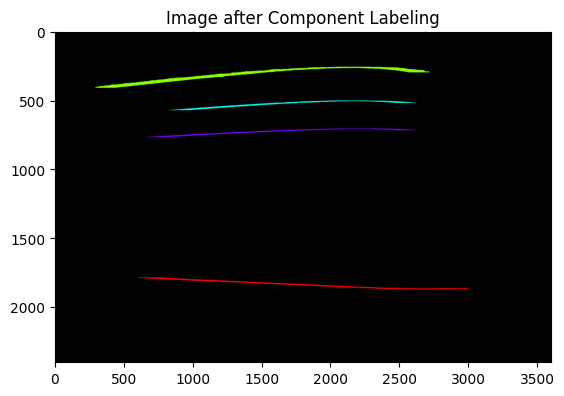

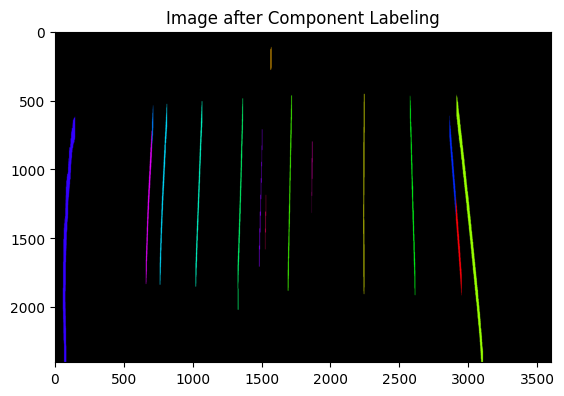

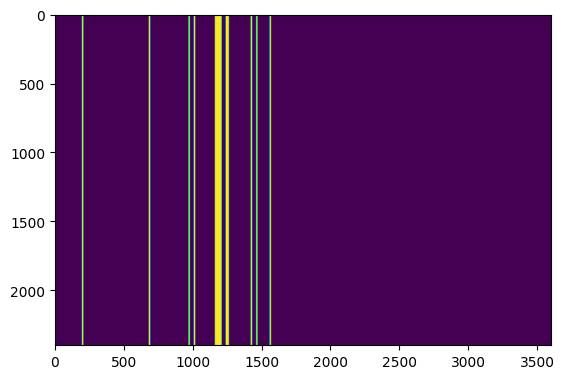

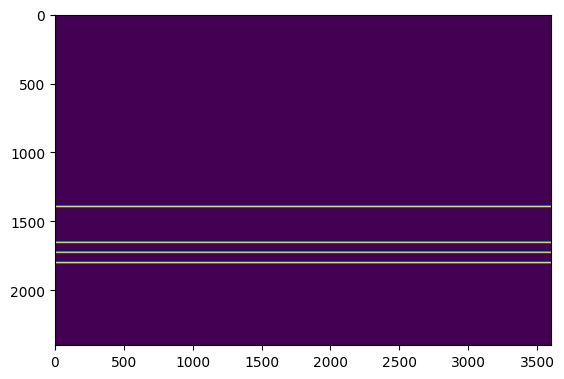

In [120]:
# Grouping image pixels
filtered_img_bin_v = filter_out_small_lines(img_bin_v, 50)
filtered_img_bin_h = filter_out_small_lines(img_bin_h, 3000)

filtered_img_bin_v, l_v, cl_v = get_clean_lines((filtered_img_bin_v>0).astype(np.uint8), 50, True)
filtered_img_bin_h, l_h, cl_h = get_clean_lines((filtered_img_bin_h>0).astype(np.uint8), 3000, False)
print(l_v, l_h)
plot_islands(filtered_img_bin_h, filtered_img_bin_v);
plt.imshow(cl_v)
plt.show()
plt.imshow(cl_h);
plt.show()

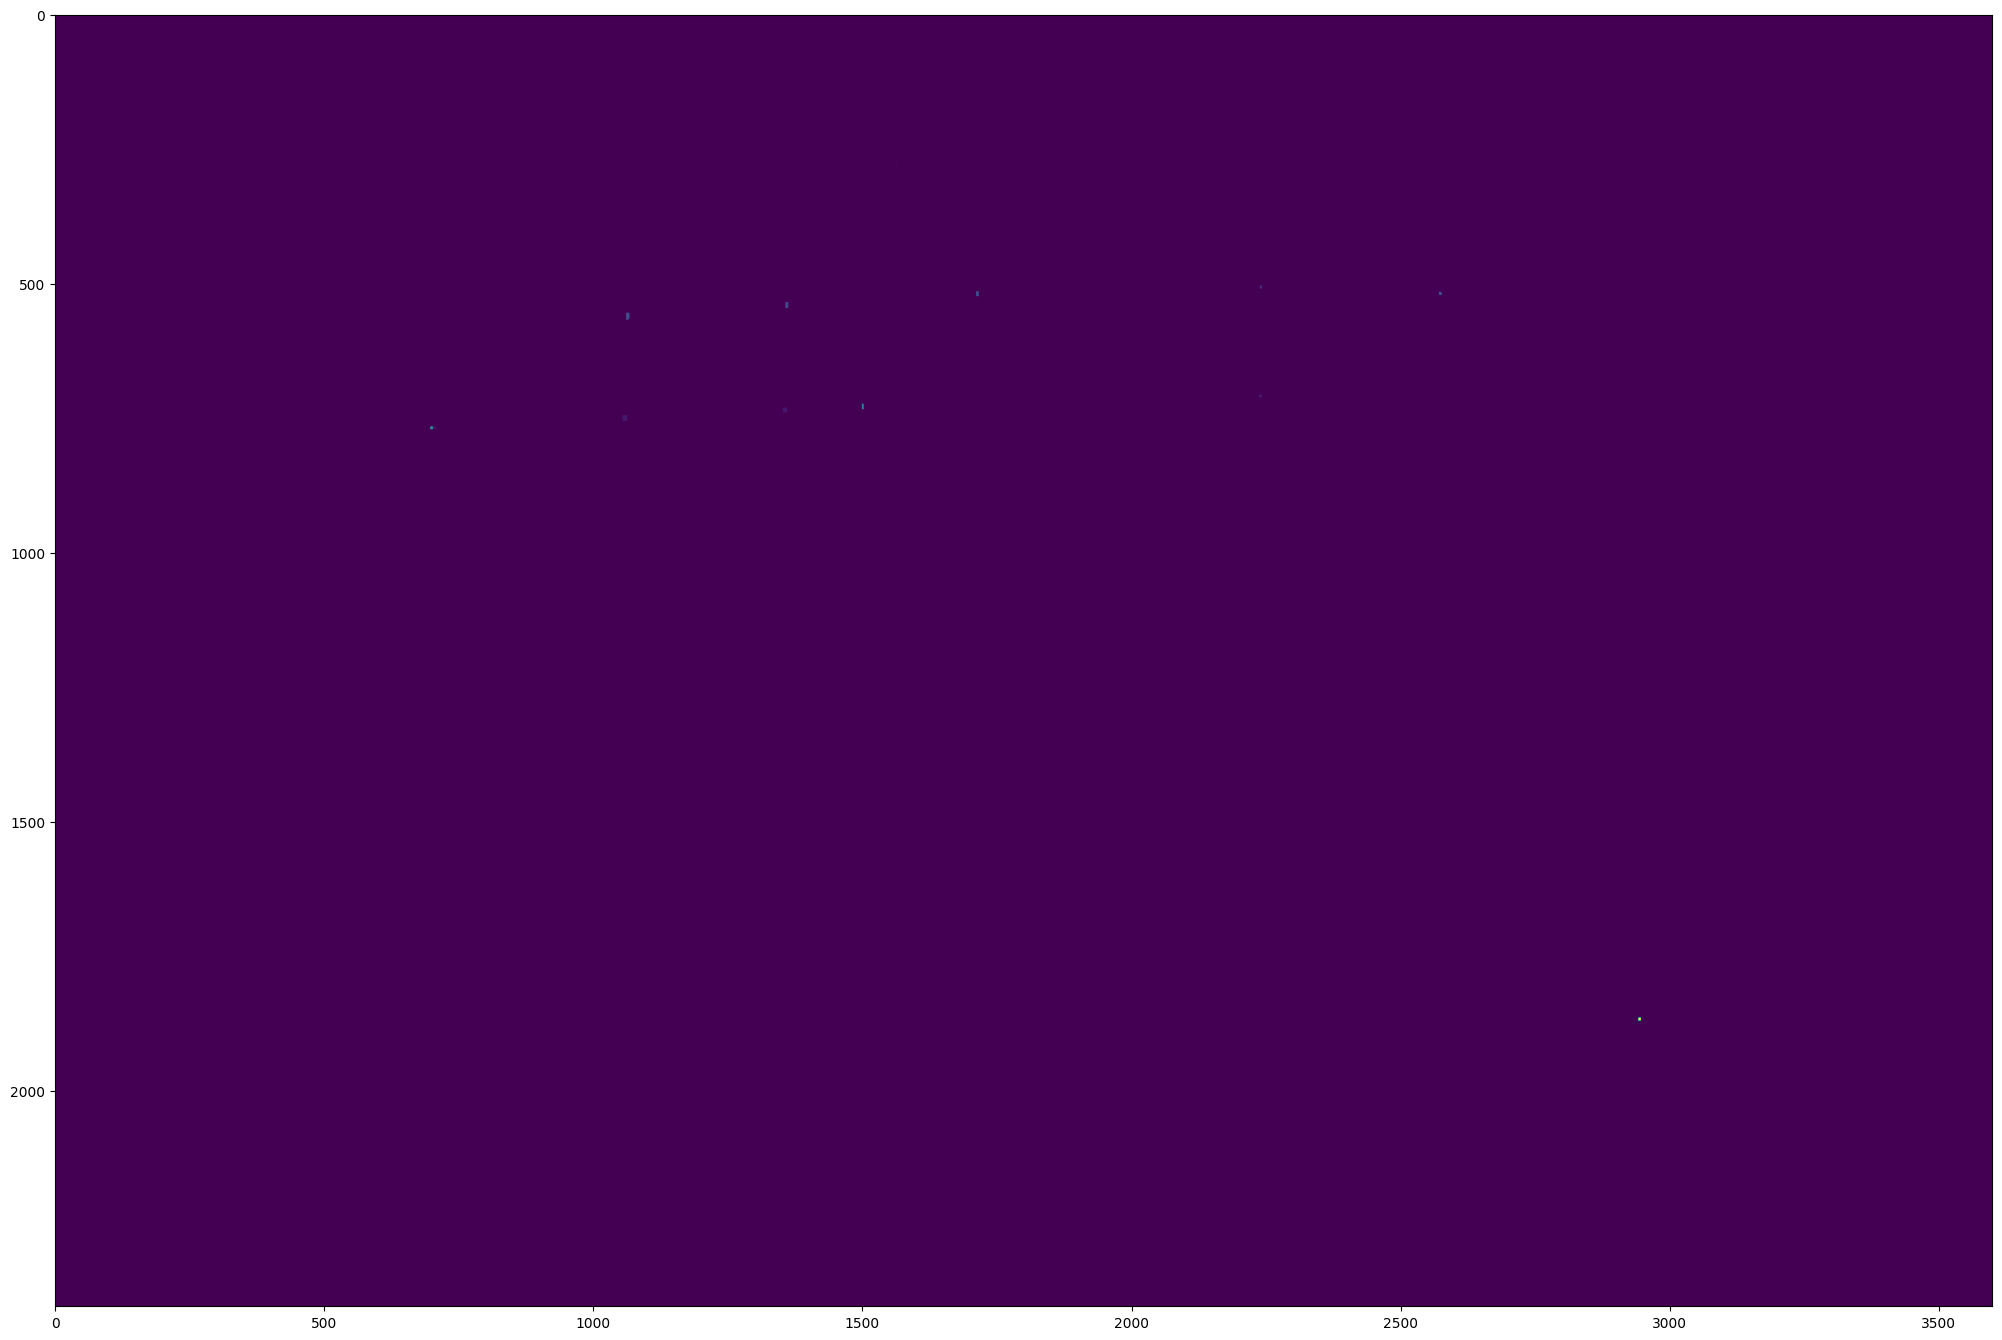

In [67]:
intersected = (img_bin_v&img_bin_h)
intersected_f = (filtered_img_bin_v&filtered_img_bin_h)

plt.figure(figsize=(25,25))
plt.imshow(intersected_f)

# Clustering

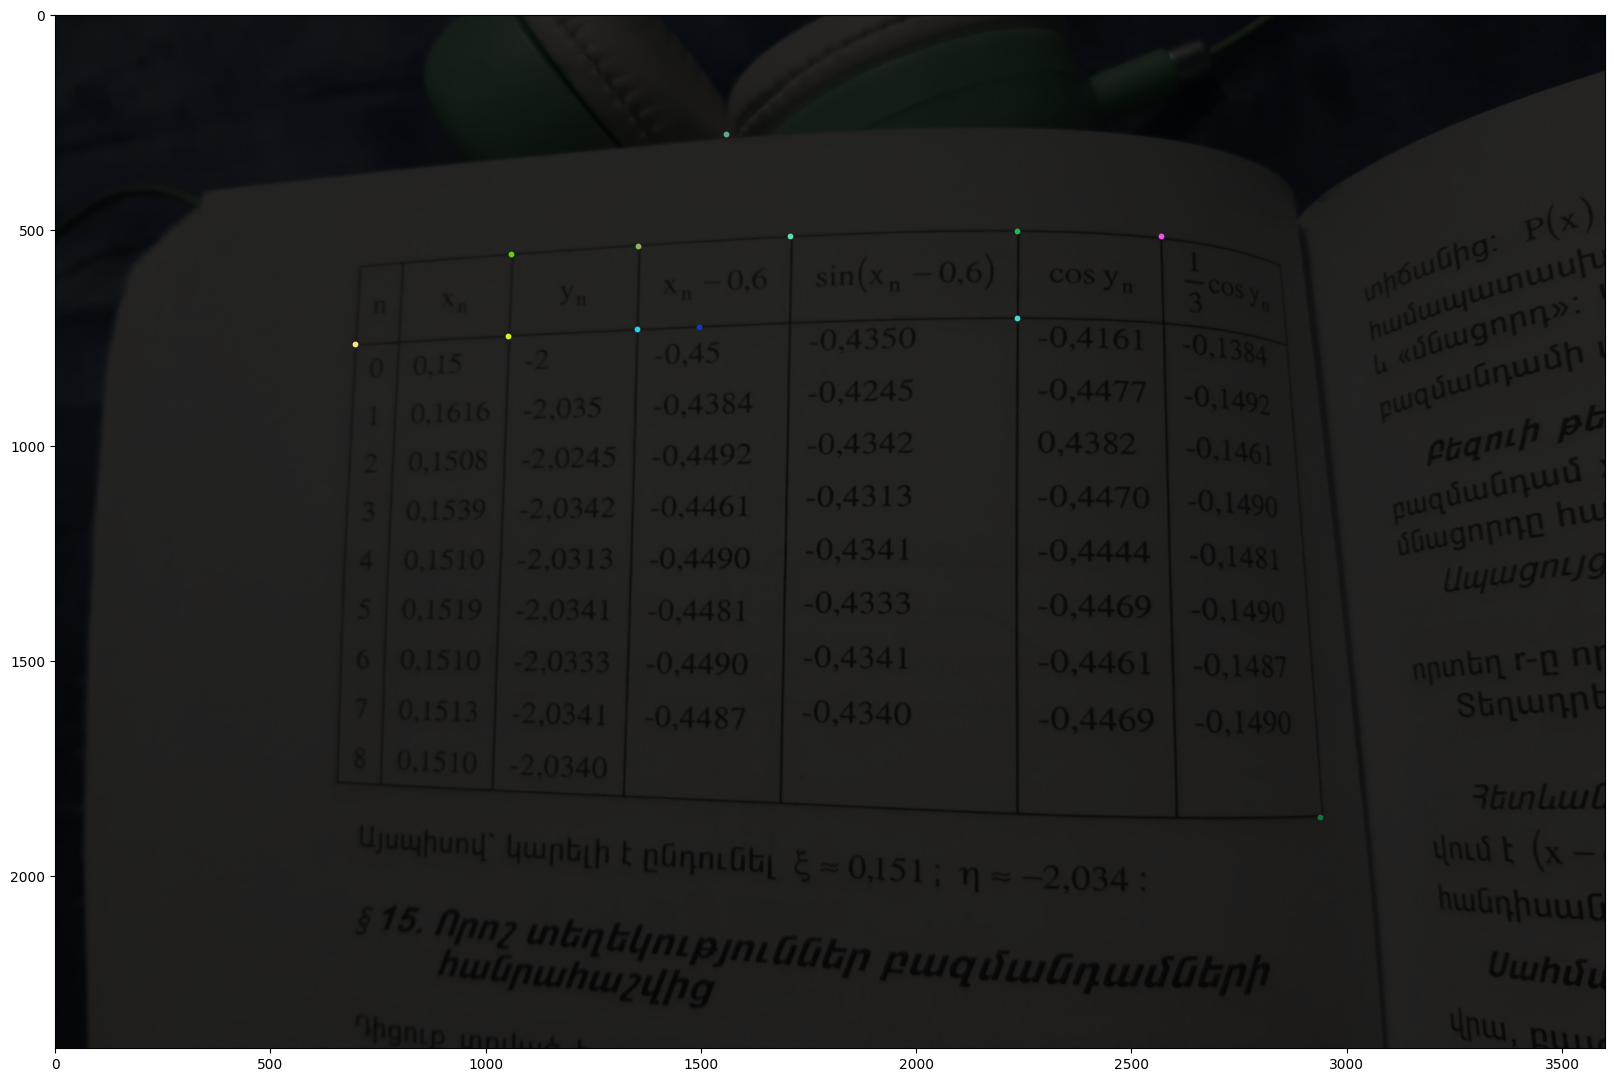

In [68]:
# scipy Agglomerative clustering class instance
AGC_ = AGC(n_clusters=None, distance_threshold=50)

#Finding the points
points = np.stack(np.where(intersected_f>0)).transpose(1,0)
clustered=(AGC_.fit_predict(points))

# Separating the unique clusters
uniques_ = np.unique(clustered)

# Centers for each unique cluster
box_points = []

plt.figure(figsize=(20,20))
plt.imshow((img.permute(1,2,0).numpy()*0.2).astype(np.uint8))
for unique_ in uniques_:
    area_points = points[ np.where(clustered==unique_)[0] ]
    box_points.append(np.mean(area_points,axis=0))
    plt.scatter(box_points[-1][1]-5,box_points[-1][0]-5,color=tuple(np.random.random(3)), marker="o", s=10 )
plt.show()
box_points = np.array(box_points, dtype=int)

In [20]:
import math

In [ ]:
myradians = math.atan2(targetY-gunY, targetX-gunX)
mydegrees = math.degrees(myradians)

In [ ]:
print("LORE")

In [10]:
# Find the nearest point by x and y
x = box_points[:,0]
y = box_points[:,1] 

def get_nearest_points(x):
    # Pair each element with other elements
    dist_matrix = (x_-x_[...,None])
    # Zero down all elements of the symetric matrix for not taking one point twice
    dist_matrix = np.triu(dist_matrix, k=1)
    # Set a high number to those zeroed
    dist_matrix[dist_matrix==0]=10000
 
    return (np.abs(dist_matrix)).argmin(axis=0) ## Nearest point from bottom or right

def distance(x,y):
    x_d = (x[...,None] - x)
    y_d = (y[...,None] - y)
#     x_d[x_d<0] = 0
#     y_d[y_d<0] = 0
    
#     print(x_dist_matrix,x_dist_matrix.shape)
    dist_matrix = np.sqrt(x_d**2+y_d**2)
    dist_matrix[dist_matrix==0] = np.nan
    return np.nanargmin(dist_matrix, axis=0)
    
mask = distance(x,y)
    
# # Get right bottom points (X,Y) for each point
# rb_x = get_nearest_points(x).astype(int)
# rb_y = get_nearest_points(y).astype(int)
plt.figure(figsize=(20,20))
plt.imshow(rects)
for i in range(2):#range(rb_x.shape[0]):
#     print((y[i],x[i]), (x[rb_x[i]],y[rb_y[i]]))
    plt.scatter(y[i],x[i])
    print(rb_y[i],rb_x[i] )
    plt.scatter(y[mask[i]],x[mask[i]])
#     rects = cv2.rectangle(rects, (x[i],y[i]), (x[rb_x[i]],y[rb_y[i]]), color=(255,0,0) )
plt.show()

NameError: name 'rects' is not defined

<Figure size 2000x2000 with 0 Axes>

# Subtracting text from `Vertical` lines (NO)

In [ ]:
vline = feature_images[1][17]
hline = feature_images[1][9]
text_ = feature_images[3][63]
no_text = feature_images[3][44]

v_b = vline>get_n_percent_val(vline, 0.95)
h_b = hline>get_n_percent_val(vline, 0.95)
fig, ax = plt.subplots(2,3,figsize=(30,20))
ax[0,0].imshow(v_b)
ax[0,1].imshow(h_b)
ax[0,2].imshow(no_text>get_n_percent_val(no_text, 0.5))
print(v_b.sum())
v_b[hline>0]=0
v_b[text_>0]=0
print(v_b.sum())

ax[1,0].imshow(v_b)
plt.tight_layout()
plt.show()
# plt.imshow(text_>50)

# Plotting All features (Visualisation)

In [ ]:
feature_list = img.clone()

for i, feature in tqdm(enumerate(vgg16_.features[0:2])):
    feature_list = feature(feature_list)
    plot_features(feature_list.to(torch.uint8).cpu(), feature, i)


# Harris Corner Finding (NO)

In [ ]:
img__ = feature_images[1][20].clone()
img__[img__>0]=255
img__ = img__.numpy().astype(np.float32)
img__.dtype

In [ ]:
dst = cv2.cornerHarris(cv2.cvtColor(img.permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY).astype(np.float32),5,21,0.0001)
# #result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
plt.figure(figsize=(20,20))
plt.imshow(dst)
plt.show()

# # Threshold for an optimal value, it may vary depending on the image.
# img[dst>0.01*dst.max()]=[0,0,255]
# plt.imshow(img)